In [1]:
%load_ext Cython

In [2]:
import numpy as np
import pandas as pd
import scipy.sparse as sp
import matplotlib.pyplot as pyplot
import optuna as op
%matplotlib inline
from Data_manager.split_functions.split_train_validation_random_holdout import split_train_in_two_percentage_global_sample
from Evaluation.Evaluator import EvaluatorHoldout
from Recommenders.KNN.ItemKNNCFRecommender import ItemKNNCFRecommender

In [3]:
dataset = pd.read_csv('../Input/interactions_and_impressions.csv')
dataset = dataset.drop(columns=['Impressions'])

datasetCOO = sp.coo_matrix((dataset["Data"].values, (dataset["UserID"].values, dataset["ItemID"].values)))
userIDS = dataset['UserID'].unique()
itemIDS = dataset['ItemID'].unique()

URM = np.zeros((len(userIDS), len(itemIDS)), dtype=int)
for x in range(len(datasetCOO.data)):
    if datasetCOO.data[x] == 0:
        URM[datasetCOO.row[x]][datasetCOO.col[x]] = int(1)

URM = sp.csr_matrix(URM)

/var/folders/tt/9v6608x550n51759gpcrffsc0000gn/T/ipykernel_12146/4045740091.py:1: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  dataset = pd.read_csv('../Input/interactions_and_impressions.csv')


In [4]:
URM_train, URM_test = split_train_in_two_percentage_global_sample(URM, train_percentage = 0.80)
URM_train, URM_validation = split_train_in_two_percentage_global_sample(URM_train, train_percentage = 0.80)

In [5]:
evaluator_validation = EvaluatorHoldout(URM_validation, cutoff_list=[10])
evaluator_test = EvaluatorHoldout(URM_test, cutoff_list=[10])

EvaluatorHoldout: Ignoring 2679 ( 6.4%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 1580 ( 3.8%) Users that have less than 1 test interactions


## Number of Neighbors

In [6]:
x_tick = [10, 25, 40, 50, 100]
MAP_per_k = []

for topK in x_tick:

    recommender = ItemKNNCFRecommender(URM_train)
    recommender.fit(shrink=0.0, topK=topK)

    result_df, _ = evaluator_validation.evaluateRecommender(recommender)

    MAP_per_k.append(result_df.loc[10]["MAP"])

ItemKNNCFRecommender: URM Detected 5 ( 0.0%) users with no interactions.
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 24507 (100.0%), 494.97 column/sec. Elapsed time 49.51 sec
EvaluatorHoldout: Processed 38943 (100.0%) in 30.62 sec. Users per second: 1272
ItemKNNCFRecommender: URM Detected 5 ( 0.0%) users with no interactions.
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 24507 (100.0%), 449.01 column/sec. Elapsed time 54.58 sec


KeyboardInterrupt: 

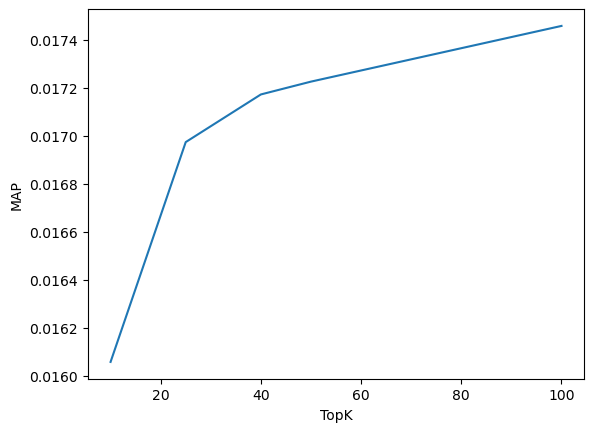

In [23]:
pyplot.plot(x_tick, MAP_per_k)
pyplot.ylabel('MAP')
pyplot.xlabel('TopK')
pyplot.show()

Let's take topK=23

## Shrinkage

In [24]:
x_tick = [0, 10, 50, 100, 200]
MAP_per_shrinkage = []

for shrink in x_tick:

    recommender = ItemKNNCFRecommender(URM_train)
    recommender.fit(shrink=shrink, topK=100)

    result_df, _ = evaluator_validation.evaluateRecommender(recommender)

    MAP_per_shrinkage.append(result_df.loc[10]["MAP"])

ItemKNNCFRecommender: URM Detected 6 ( 0.0%) users with no interactions.
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 24507 (100.0%), 1632.31 column/sec. Elapsed time 15.01 sec
EvaluatorHoldout: Processed 38894 (100.0%) in 17.25 sec. Users per second: 2255
ItemKNNCFRecommender: URM Detected 6 ( 0.0%) users with no interactions.
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 24507 (100.0%), 1603.38 column/sec. Elapsed time 15.28 sec
EvaluatorHoldout: Processed 38894 (100.0%) in 17.55 sec. Users per second: 2216
ItemKNNCFRecommender: URM Detected 6 ( 0.0%) users with no interactions.
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 24507 (100.0%), 1632.11 column/sec. Elapsed time 15.02 sec
EvaluatorHoldout: Processed 38894 (100.0%) in 18.83 sec. Users per second: 2066
ItemKNNCFRecommender: URM Detected 6 ( 0.0%) users with no interactions.
Unable to load Cython Compute_Similarity, reverting

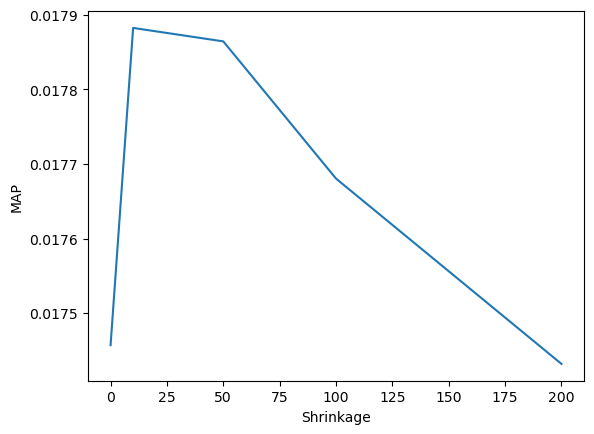

In [25]:
pyplot.plot(x_tick, MAP_per_shrinkage)
pyplot.ylabel('MAP')
pyplot.xlabel('Shrinkage')
pyplot.show()

Let's take shrinkage = 100

## Testing of reccomenders

In [20]:
collaborative_recommender1 = ItemKNNCFRecommender(URM_train)
# collaborative_recommender1.fit(shrink=10, topK=20)

collaborative_recommender2 = ItemKNNCFRecommender(URM_train)
# collaborative_recommender2.fit(shrink=100, topK=25)

collaborative_MAP1 = []
collaborative_MAP2 = []

x_tick = []

for topK in [20, 25]:
    for shrink in [10, 100]:
        x_tick.append("topk {}, shrink {}".format(topK, shrink))

        collaborative_recommender1.fit(shrink=shrink, topK=topK)
        collaborative_recommender2.fit(shrink=shrink, topK=topK)

        result_df, _ = evaluator_test.evaluateRecommender(collaborative_recommender1)
        collaborative_MAP1.append(result_df.loc[10]["MAP"])

        result_df, _ = evaluator_test.evaluateRecommender(collaborative_recommender2)
        collaborative_MAP2.append(result_df.loc[10]["MAP"])

ItemKNNCFRecommender: URM Detected 7 ( 0.0%) users with no interactions.
ItemKNNCFRecommender: URM Detected 7 ( 0.0%) users with no interactions.
Unable to load Cython Compute_Similarity, reverting to Python


KeyboardInterrupt: 

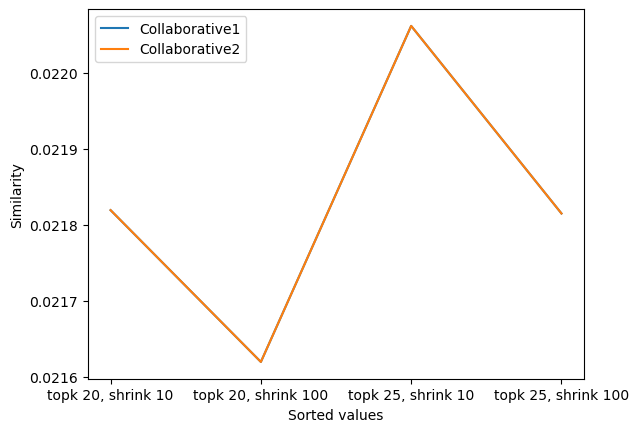

In [17]:
pyplot.plot(x_tick, collaborative_MAP1, label="Collaborative1")
pyplot.plot(x_tick, collaborative_MAP2, label="Collaborative2")

pyplot.ylabel('Similarity')
pyplot.xlabel('Sorted values')
pyplot.legend()
pyplot.show()

## OPTUNA optimization

In [6]:
recommender = ItemKNNCFRecommender(URM_train)

def objective(trial):
    topK = trial.suggest_float("topK", 20, 500)
    shrink = trial.suggest_float("shrink", 0, 100)
    recommender.fit(topK=int(topK), shrink=shrink)
    result_dict, _ = evaluator_validation.evaluateRecommender(recommender)

    return result_dict.loc[10]["MAP"]

ItemKNNCFRecommender: URM Detected 6 ( 0.0%) users with no interactions.


In [7]:
# objective = represents the function that we need to minimize
# trial = optuna parameter that tries random values in a certain interval

def objective(trial):
    topK = trial.suggest_float("topK", 20, 60)
    shrink = trial.suggest_float("shrink", 5, 25)
    recommender.fit(topK=int(topK), shrink=shrink)
    result_dict, _ = evaluator_validation.evaluateRecommender(recommender)

    return result_dict.loc[10]["MAP"]

In [8]:
study = op.create_study(direction='maximize')
study.optimize(objective, n_trials=10)

[I 2022-11-04 22:33:48,248] A new study created in memory with name: no-name-2c7fe412-baed-4434-897e-2384206a17d0


Similarity column 24507 (100.0%), 9445.82 column/sec. Elapsed time 2.59 sec
EvaluatorHoldout: Processed 38950 (100.0%) in 14.75 sec. Users per second: 2640


[I 2022-11-04 22:34:05,658] Trial 0 finished with value: 0.017527730912647296 and parameters: {'topK': 51.671247960899215, 'shrink': 24.222108288044993}. Best is trial 0 with value: 0.017527730912647296.


Similarity column 24507 (100.0%), 9741.93 column/sec. Elapsed time 2.52 sec
EvaluatorHoldout: Processed 38950 (100.0%) in 13.75 sec. Users per second: 2834


[I 2022-11-04 22:34:21,946] Trial 1 finished with value: 0.017099333700103816 and parameters: {'topK': 30.77503577741142, 'shrink': 6.37058266038554}. Best is trial 0 with value: 0.017527730912647296.


Similarity column 24507 (100.0%), 9716.44 column/sec. Elapsed time 2.52 sec
EvaluatorHoldout: Processed 38950 (100.0%) in 14.41 sec. Users per second: 2702


[I 2022-11-04 22:34:38,917] Trial 2 finished with value: 0.01732825865476679 and parameters: {'topK': 56.34325514565549, 'shrink': 6.564217307838131}. Best is trial 0 with value: 0.017527730912647296.


Similarity column 24507 (100.0%), 9740.47 column/sec. Elapsed time 2.52 sec
EvaluatorHoldout: Processed 38950 (100.0%) in 13.96 sec. Users per second: 2791


[I 2022-11-04 22:34:55,414] Trial 3 finished with value: 0.01729144201968318 and parameters: {'topK': 30.897865189762463, 'shrink': 16.56199471475656}. Best is trial 0 with value: 0.017527730912647296.


Similarity column 24507 (100.0%), 9738.84 column/sec. Elapsed time 2.52 sec
EvaluatorHoldout: Processed 38950 (100.0%) in 13.72 sec. Users per second: 2840


[I 2022-11-04 22:35:11,668] Trial 4 finished with value: 0.01705733031766398 and parameters: {'topK': 23.31234793927182, 'shrink': 13.128887445248829}. Best is trial 0 with value: 0.017527730912647296.


Similarity column 24507 (100.0%), 9754.03 column/sec. Elapsed time 2.51 sec
EvaluatorHoldout: Processed 38950 (100.0%) in 13.95 sec. Users per second: 2792


[I 2022-11-04 22:35:28,156] Trial 5 finished with value: 0.017175211402489912 and parameters: {'topK': 21.56312240341157, 'shrink': 23.94682707417983}. Best is trial 0 with value: 0.017527730912647296.


Similarity column 24507 (100.0%), 9701.47 column/sec. Elapsed time 2.53 sec
EvaluatorHoldout: Processed 38950 (100.0%) in 14.56 sec. Users per second: 2676


[I 2022-11-04 22:35:45,267] Trial 6 finished with value: 0.017364435478941082 and parameters: {'topK': 55.25710611808226, 'shrink': 6.796641177055274}. Best is trial 0 with value: 0.017527730912647296.


Similarity column 24507 (100.0%), 9651.95 column/sec. Elapsed time 2.54 sec
EvaluatorHoldout: Processed 38950 (100.0%) in 14.31 sec. Users per second: 2721


[I 2022-11-04 22:36:02,143] Trial 7 finished with value: 0.017255382358334712 and parameters: {'topK': 28.52334025744691, 'shrink': 23.766956652500507}. Best is trial 0 with value: 0.017527730912647296.


Similarity column 24507 (100.0%), 9629.36 column/sec. Elapsed time 2.55 sec
EvaluatorHoldout: Processed 38950 (100.0%) in 14.81 sec. Users per second: 2630


[I 2022-11-04 22:36:19,529] Trial 8 finished with value: 0.01751475945962448 and parameters: {'topK': 51.81428956189145, 'shrink': 19.902516943885807}. Best is trial 0 with value: 0.017527730912647296.


Similarity column 24507 (100.0%), 9587.02 column/sec. Elapsed time 2.56 sec
EvaluatorHoldout: Processed 38950 (100.0%) in 14.20 sec. Users per second: 2742


[I 2022-11-04 22:36:36,315] Trial 9 finished with value: 0.017383082706766743 and parameters: {'topK': 38.070384675777085, 'shrink': 15.371465436520353}. Best is trial 0 with value: 0.017527730912647296.


In [9]:
topK = study.best_params['topK']
shrink = study.best_params['shrink']

In [10]:
topK

51.671247960899215

In [11]:
shrink

24.222108288044993

In [18]:
# BEST
recommender.fit(shrink=int(11.360087017080575), topK=int(24.286589663434658))
result_df, _ = evaluator_test.evaluateRecommender(recommender)
result_df

Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 24507 (100.0%), 2239.63 column/sec. Elapsed time 10.94 sec
EvaluatorHoldout: Processed 40049 (100.0%) in 14.52 sec. Users per second: 2757


,PRECISION,PRECISION_RECALL_MIN_DEN,RECALL,MAP,MAP_MIN_DEN,MRR,NDCG,F1,HIT_RATE,ARHR_ALL_HITS,...,COVERAGE_USER,COVERAGE_USER_HIT,USERS_IN_GT,DIVERSITY_GINI,SHANNON_ENTROPY,RATIO_DIVERSITY_HERFINDAHL,RATIO_DIVERSITY_GINI,RATIO_SHANNON_ENTROPY,RATIO_AVERAGE_POPULARITY,RATIO_NOVELTY
cutoff,,,,,,,,,,,,,,,,,,,,,
10,0.046321,0.079588,0.074875,0.021972,0.037271,0.146416,0.074062,0.057234,0.306824,0.178098,...,0.962046,0.295179,0.962046,0.06312,9.998054,0.996586,0.144911,0.758633,2.655495,0.521819


In [12]:
recommender.fit(shrink=int(24.222108288044993), topK=int(51.671247960899215))
result_df, _ = evaluator_test.evaluateRecommender(recommender)
result_df

Similarity column 24507 (100.0%), 9564.72 column/sec. Elapsed time 2.56 sec
EvaluatorHoldout: Processed 40049 (100.0%) in 15.22 sec. Users per second: 2631


,PRECISION,PRECISION_RECALL_MIN_DEN,RECALL,MAP,MAP_MIN_DEN,MRR,NDCG,F1,HIT_RATE,ARHR_ALL_HITS,...,COVERAGE_USER,COVERAGE_USER_HIT,USERS_IN_GT,DIVERSITY_GINI,SHANNON_ENTROPY,RATIO_DIVERSITY_HERFINDAHL,RATIO_DIVERSITY_GINI,RATIO_SHANNON_ENTROPY,RATIO_AVERAGE_POPULARITY,RATIO_NOVELTY
cutoff,,,,,,,,,,,,,,,,,,,,,
10,0.04703,0.081784,0.07714,0.022538,0.038561,0.151745,0.076298,0.058434,0.314165,0.183661,...,0.962046,0.302241,0.962046,0.047511,9.523232,0.99554,0.109023,0.722592,2.979664,0.504982
